# Weight initialization

Some experiments to examine the impact of weight initialization on the distribution of activations on each layer in neural network, especially the very last layers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import get_CIFAR10_data

% matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
X_train = data['X_train']
X_train_flat = X_train.reshape((-1, 32*32*3))
X_train_normalized = (X_train_flat - X_train_flat.mean(axis=0)) / (X_train_flat.std(axis=0) + 1e-8)

In [5]:
def relu(x):
    return np.maximum(x, 0)

def forward(X_flat, hid_dims, weights, biases, activation=relu):
    """
    Feed forward.
     - X_flat: shape: N x D, where D = d1 x ... x dk.
     - hid_dims: 1D array.
     - weights: array of weights: W1, W2, ...
     - biases: array of biases: b1, b2, ...
     - activation: activation on each layer. None if no activation.
    """
    assert len(weights) == len(biases), 'weights and biases must have the same length'
    assert len(hid_dims) + 1 == len(weights), 'len(weights) must equal len(hid_dims) + 1'
    
    all_layers = []
    out = X_flat
    for l in range(len(hid_dims) + 1):
        out = np.dot(out, weights[l]) + biases[l]
        if activation is not None:
            out = activation(out)
        all_layers.append(out)
    
    return out, all_layers

In [18]:
def visualize_distribution(all_activations):
    n_layers = len(all_activations)
    activations_mean = [np.asscalar(np.mean(activations)) for activations in all_activations]
    activations_std = [np.asscalar(np.std(activations)) for activations in all_activations]
    
    xs = range(1, n_layers+1)
    _, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
    ax1.plot(xs, activations_mean, '-o', color='#0067a7')
    ax1.set_title('means by layer')
    ax1.set_xlabel('layer')
    ax2.plot(xs, activations_std, '-o', color='red')
    ax2.set_title('std by layer')
    ax2.set_xlabel('layer')
    
    ax3.hist(all_activations[14].ravel(), bins=50, color='green')
    ax3.set_title('(avtivations) distribution of layer 15')
    ax4.hist(all_activations[-1].ravel(), bins=50, color='green')
    ax4.set_title('(avtivations) distribution of the last layer')
    
    plt.show()
    
    # Print mean and std of last 5 layer
    for l in range(n_layers)[-5:]:
        print('Layer %2d. mean: %f\tstd: %f' % (l+1, activations_mean[l], activations_std[l]))
    
def initialize_params(in_dim, hid_dims, out_dim,
                      weight_initializer=np.random.randn,
                      bias_initializer=np.zeros):
    dims = [in_dim] + hid_dims + [out_dim]
    weights, biases = [], []
    for l in range(len(hid_dims) + 1):
        w = weight_initializer(dims[l], dims[l+1])
        b = bias_initializer(dims[l+1])
        weights.append(w)
        biases.append(b)
    return weights, biases

def examine_distribution(weight_initializer, activation=relu):
    n_layers = 20
    in_dim, out_dim = 32*32*3, 10
    hid_dims = [100 for i in range(n_layers - 1)]
    
    weights, biases = initialize_params(in_dim, hid_dims, out_dim,
        weight_initializer=weight_initializer)
    
    _, all_activations = forward(X_train_normalized, hid_dims=hid_dims, 
        weights=weights, biases=biases, activation=activation)
    
    visualize_distribution(all_activations)

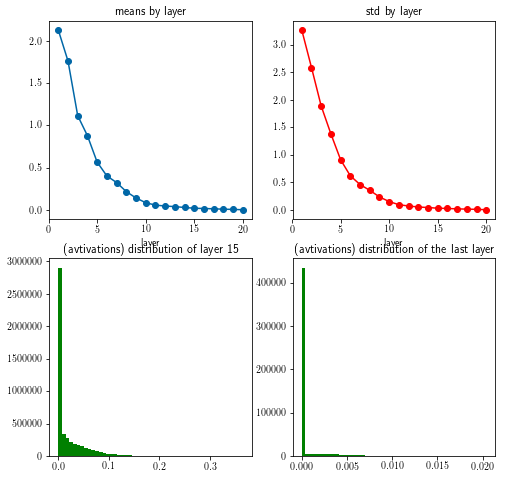

Layer 16. mean: 0.015186	std: 0.024572
Layer 17. mean: 0.011610	std: 0.017358
Layer 18. mean: 0.006918	std: 0.012631
Layer 19. mean: 0.004776	std: 0.009074
Layer 20. mean: 0.000393	std: 0.001330


In [19]:
def trivial_initializer(d1, d2, weight_scale=0.1):
    return np.random.normal(0, weight_scale, (d1, d2))

examine_distribution(trivial_initializer)

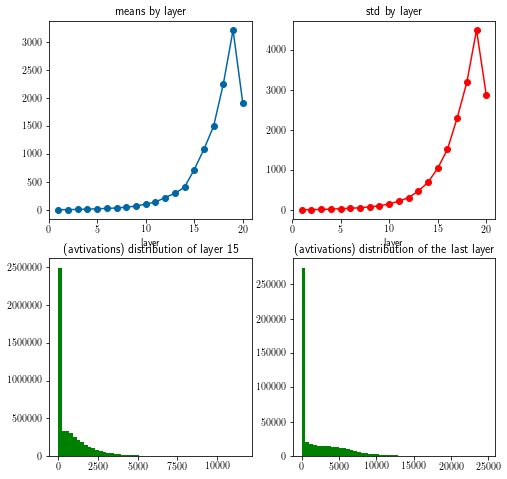

Layer 16. mean: 1084.297861	std: 1515.693153
Layer 17. mean: 1498.353442	std: 2291.632540
Layer 18. mean: 2249.923612	std: 3189.201041
Layer 19. mean: 3212.197276	std: 4492.954650
Layer 20. mean: 1915.103524	std: 2872.041885


In [20]:
examine_distribution(lambda d1, d2: trivial_initializer(d1, d2, weight_scale=0.2))

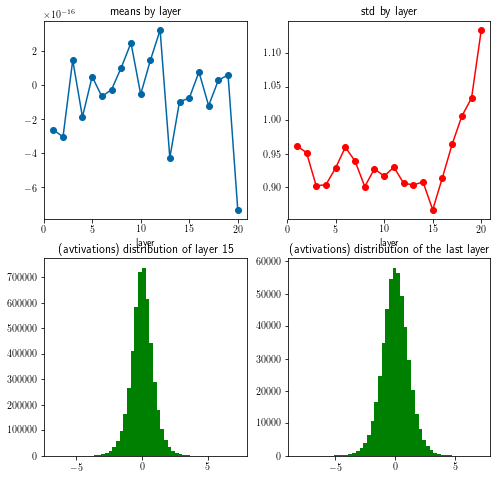

Layer 16. mean: 0.000000	std: 0.914272
Layer 17. mean: -0.000000	std: 0.963951
Layer 18. mean: 0.000000	std: 1.005893
Layer 19. mean: 0.000000	std: 1.032978
Layer 20. mean: -0.000000	std: 1.134366


In [21]:
def xavier_initializer_1(d1, d2):
    return np.random.randn(d1, d2) * np.sqrt(1.0 / d1)

examine_distribution(xavier_initializer_1, activation=None)

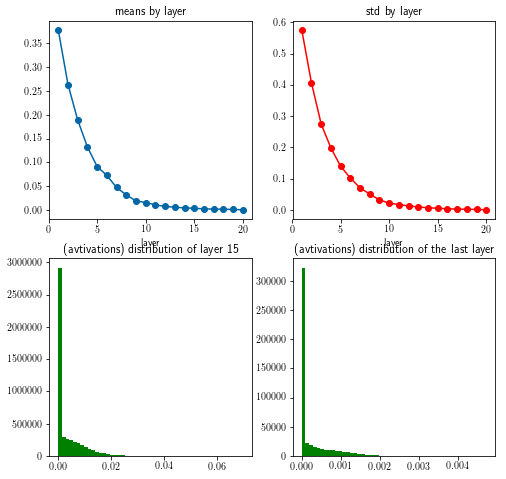

Layer 16. mean: 0.002120	std: 0.003683
Layer 17. mean: 0.001694	std: 0.002493
Layer 18. mean: 0.001372	std: 0.002067
Layer 19. mean: 0.000854	std: 0.001404
Layer 20. mean: 0.000242	std: 0.000439


In [22]:
examine_distribution(xavier_initializer_1, activation=relu)

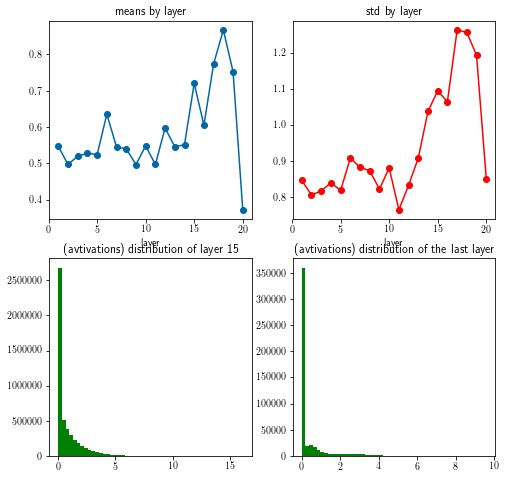

Layer 16. mean: 0.604963	std: 1.064217
Layer 17. mean: 0.773884	std: 1.262909
Layer 18. mean: 0.866719	std: 1.256430
Layer 19. mean: 0.752614	std: 1.193166
Layer 20. mean: 0.372393	std: 0.851158


In [23]:
def xavier_initializer_2(d1, d2):
    return np.random.randn(d1, d2) * np.sqrt(2.0 / d1)

examine_distribution(xavier_initializer_2)